## Image Editing

The purpose of editing is the alteration of digital images usually to perform improvement of its properties, or to turn them into an intermediate step for further processing.  

Let us examine different examples of editing.

* *Transformations of the domain*
* *Intensity adjustment*
* *Image restoration*
* *Image inpainting*

### Transformations of the domain

In this setting we address transformations to images by changing first the location of pixels: rotations, compressions, stretching, swirls, cropping, perspective control, etc.  Once the transformation to the pixels in the domain of the original is performed, we observe the size of the output.   If there are more pixels in this image than in the original, the extra locations are filled with numerical values obtained by interpolating the given data.  We do have some control over the kind of interpolation performed, of course.  To better illustrate these techniques, we will pair an actual image (say, Lena) with a representation of its domain as a checkerboard.


In [2]:
import numpy as np, matplotlib.pyplot as plt

%matplotlib inline

from scipy.misc import lena
from skimage.data import checkerboard

image = lena().astype('float')
domain = checkerboard()

print image.shape, domain.shape

(512, 512) (200, 200)


#### Rescale and resize

Before we proceed with the pairing of image and domain, we have to make sure that they both have the same size.  One quick fix is to *rescale* both objects, or simply resize one of the images to match the size of the other.  Let us go with the first choice, so we can illustrate the usage of the two functions available for this task in the `skimage.transform` module: `resize` and `rescale`.  

In [3]:
from skimage.transform import rescale, resize

domain = rescale(domain, scale=1024./200)
image  = resize(image, output_shape=(1024, 1024), order=3)

Note how, in the resizing operation, we requested a bi-cubic interpolation.

#### Swirl

To perform a *swirl*, we call the function `swirl` from the module `skimage.transform`:

> In all examples in this section, we will present the results visually after performing the requested computations.  In all cases, the syntax of the call to offer the images is the same.  For a given operation `mapping`, we issue the command `display(mapping, image, domain)` where the routine `display` is defined as follows:

In [6]:
def display(mapping, image, domain):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(mapping(image))
    plt.gray()
    plt.subplot(122)
    plt.imshow(mapping(domain))
    plt.show()

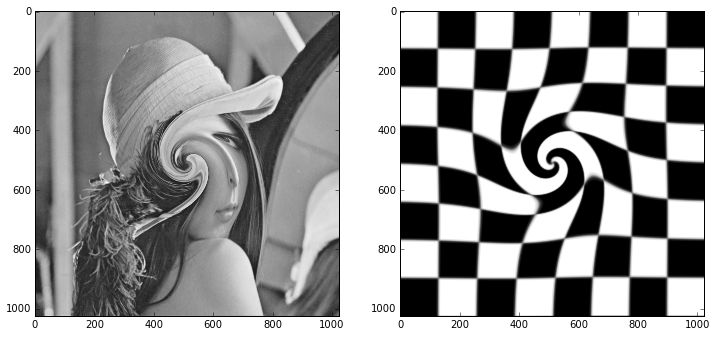

In [7]:
from skimage.transform import swirl

mapping = lambda img: swirl(img, strength=6, radius=512)

display(mapping, image, domain)

#### Geometric Transformations

A simple rotation around any location (no matter whether inside or outside the domain of the image) can be achieved with the function `rotate` from either module `scipy.ndimage` or `skimage.transform`.  They are basically the same under the hood, but the syntax of the function in the `scikit-image` toolkit is somewhat more user-friendly.

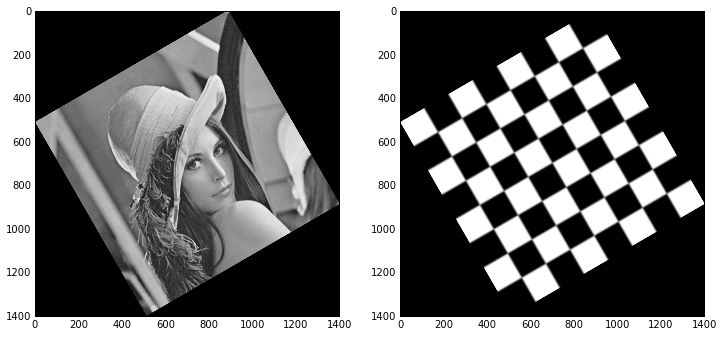

In [8]:
from skimage.transform import rotate

mapping = lambda img: rotate(img, angle=30, resize=True, center=None)

display(mapping, image, domain)

This gives a counter-clockwise rotation of 30 degrees (`angle=30`) around the center of the image (`center=None`).  The size of the output image is expanded to guarantee that all the original pixels are present in the output (`resize=True`).

Rotations are a special case of what we call an *affine transformation*: a combination of rotation with scales (one for each dimension), shear and translation.  Affine transformations are in turn a special case of an *homography* (a *projective transformation*).  Rather than learning a different set of functions, one for each kind of geometric transformation, the library `skimage.transform` allows a very comfortable setting:  There is a common function (`warp`), that gets called with the requested geometric transformation and performs the computations.  Each suitable geometric transformation is previously initialized with an appropriate `python` class.  For example, to perform an affine transformation with a counter-clockwise rotation angle of 30 degrees about the point with coordinates (512, -2048), and scale factors of 2 and 3 units respectively for the `x` and `y` coordinates, we issue the following.

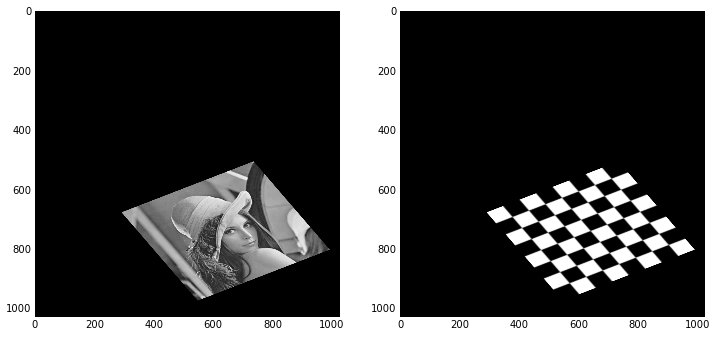

In [9]:
from skimage.transform import warp, AffineTransform

operation = AffineTransform(scale=(2,3), rotation=np.pi/6, translation = (512, -2048))

mapping = lambda img: warp(img, operation)

display(mapping, image, domain)

Note how all the lines in the transformed checkerboard are either parallel or perpendicular---affine transformations preserve angles.

The following illustrates the effect of an homography:

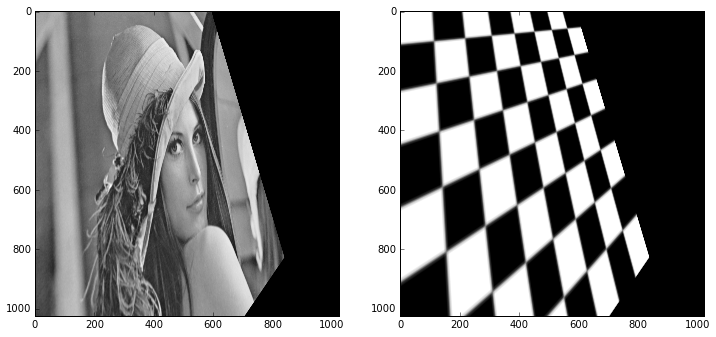

In [10]:
from skimage.transform import ProjectiveTransform

generator = np.matrix('1,0,10; 0,1,20; -0.0007,0.0005,1')
homography = ProjectiveTransform(matrix=generator)
mapping = lambda img: warp(img, homography)

display(mapping, image, domain)

Note how, unlike in the case of an affine transformation, the lines cease to be all parallel or perpendicular. All "vertical" lines are now incident at a point _at infinity_.  All "horizontal" lines are also incident at a different point at infinity.

The real usefulness of homographies arise, for example, when we need to perform *perspective control*.  For instance, the image `skimage.data.text` is clearly slanted. By choosing the four corners of what we believe is a perfect rectangle (we estimate such a rectangle by visual inspection), we can compute an homography that transforms the given image into one that is devoid of any perspective.  The `python` classes representing geometric transformations allow us to perform this estimation very easily, as the following example shows.

In [11]:
from skimage.data import text

text().shape

(172, 448)

In [12]:
source = np.array(((155, 15),  (65, 40), (260, 130), (360, 95), (155, 15)))

mapping = ProjectiveTransform()

Let us estimate the homography that transforms the given set of points into a _perfect_ rectangle of size 48-by-256 centered in an output image of size 512-by-512.  The choice of size of the output image is determined by the length of the diagonal of the original image (about 479 pixels).  This way, after the homography is computed, the output is likely to contain all the pixels from the original.

> Notice we have included one of vertices in `source` twice.  This is not strictly necessary for the computations below, but will make the visualization of rectangles much easier to code.  We use the same trick for the `target` rectangle.

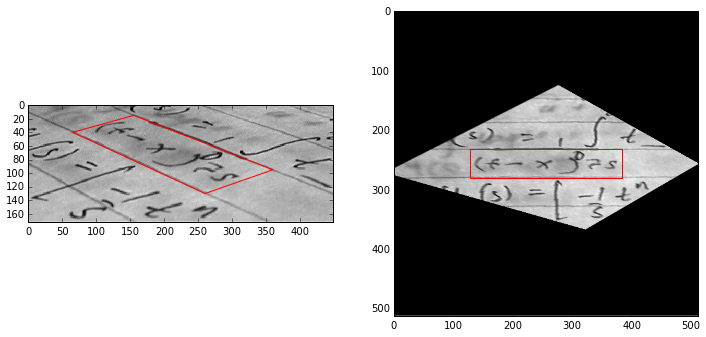

In [15]:
target = np.array(((256-128, 256-24), (256-128, 256+24), 
                   (256+128, 256+24), (256+128, 256-24), 
                   (256-128, 256-24)))

mapping.estimate(target, source)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(text())
plt.gray()
plt.plot(source[:,0], source[:,1], '-', lw=1, color='red')
plt.xlim(0, 448)
plt.ylim(172, 0)
plt.subplot(122)
plt.imshow(warp(text(), mapping, output_shape=(512, 512)))
plt.plot(target[:,0], target[:,1], '-', lw=1, color='red')
plt.xlim(0, 512)
plt.ylim(512, 0)
plt.show()

> Other more involved geometric operations are needed, for example, to fix *vignetting* and some of the other kinds of distortions produced by photographic lenses.  Traditionally, once we acquire an image we assume that all these distortions are present.  By knowing the technical specifications of the equipment used to take the photographs, we can automatically rectify these defects.  With this purpose in mind, in the `scipy` stack we have access to the `lensfun` library (http://lensfun.sourceforge.net) through the package `lensfunpy` (https://pypi.python.org/pypi/lensfunpy).  

> For examples of usage and documentation, an excellent resource is the API reference of `lensfunpy` at http://pythonhosted.org/lensfunpy/api/


### Intensity Adjustment

In this category we have operations that only modify the intensity of an image obeying a global formula.  All these operations can therefore be easily coded by using purely `numpy` operations, by creating vectorized functions adapting the requested formulas.  

The applications of these operations can be explained in terms of exposure in black-and-white photography, for example.  For this reason, all the examples in this section are applied on gray-scale images.   

We have mainly three approaches to enhancing images by working on its intensity:

* Histogram equalizations
* Intensity clipping/resizing
* Contrast adjustment

#### Histogram equalization

The starting point in this setting is always the concept of *intensity histogram* (or more precisely, the *histogram of pixel intensity values*): a function that indicates the number of pixels in an image at each different intensity value found in that image.

For instance, for the original version of Lena, we could issue


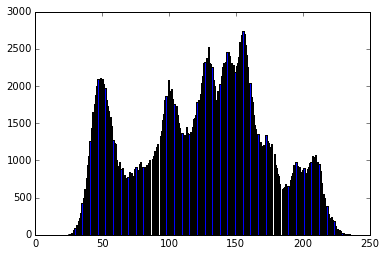

In [16]:
plt.figure()
plt.hist(lena().flatten(), 256)
plt.show()

The operations of *histogram equalization* improve the contrast of images by modifying the histogram in a way that most of the relevant intensities have the same impact.  We may accomplish this enhancement by calling from the module `skimage.exposure` any of the functions `equalize_hist` (pure histogram equalization) or `equalize_adaphist` (*CLAHE*, the *contrast limited adaptive histogram equalization*).

Note the obvious improvement after application of histogram equalization of the image `skimage.data.moon`.

> In the following examples, we include the corresponding histogram below all relevant images for comparison.  A suitable code to perform this visualization could be as follows:


In [18]:
def display(image, transform, bins):
    target = transform(image)
    plt.figure(figsize=(12,6))
    plt.subplot(221)
    plt.imshow(image)
    plt.gray()
    plt.subplot(222)
    plt.imshow(target)
    plt.subplot(223)
    plt.hist(image.flatten(), bins)
    plt.subplot(224)
    plt.hist(target.flatten(), bins)
    plt.show()

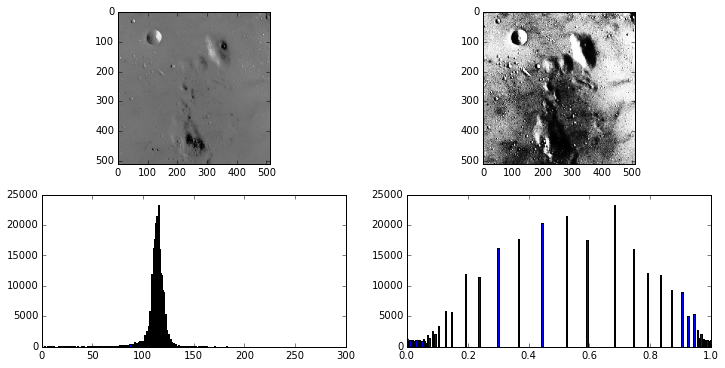

In [19]:
from skimage.exposure import equalize_hist
from skimage.data import moon

display(moon(), equalize_hist, 256) 

#### Intensity clipping/resizing

A peak in the histogram indicates the presence of a particular intensity that is remarkably more predominant than its neighboring ones.  If we desire to isolate intensities around a peak, we can do so using purely `numpy` masking/clipping operations on the original image. If storing the result is not needed, we can request a quick visualization of the result by employing the command `clim` in the library `matplotlib.pyplot`.  For instance, to isolate intensities around the highest peak of Lena (roughly, these are between 150 and 160), we could issue

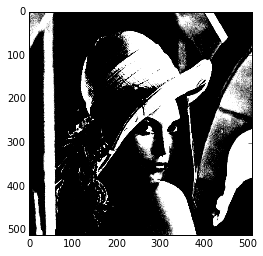

In [20]:
plt.figure()
plt.imshow(lena())
plt.gray()
plt.clim(vmin=150, vmax=160)
plt.show()

Note how this operation, in spite of having reduced the representative range of intensities from 256 to 10, offers us a new image that keeps sufficient information to recreate the original one.  Naturally, we may regard this operation also as a lossy compression method.

#### Contrast Enhancement

An obvious drawback of clipping intensities is the loss of perceived lightness contrast. To overcome this loss, it is preferable to employ formulas that do not reduce the size of the range.  Among the many available formulas conforming to this mathematical property, the most successful ones are those that replicate an optical property of the acquisition method.  We explore the following three cases:

* *Gamma correction*.  Human vision follows a power function, with greater sensitivity to relative differences between darker tones than between lighter ones.   Each original image, as captured by the acquisition device, may allocate too many bits or too much bandwidth to highlights that humans cannot actually differentiate.  Similarly, too few bits/bandwidth could be allocated to the darker areas of the image.  By manipulation of this power function, we are capable of addressing the correct amount of bits and bandwidth.
* *Sigmoid correction*.  Independently of the amount of bits and bandwidth, it is often desirable to maintain the perceived lightness contrast.  Sigmoidal remapping functions were then designed based on empirical contrast enhancement model developed from the results of psychophysical adjustment experiments.
* *Logarithmic correction* is a purely mathematical process designed to spread the range of naturally low-contrast images by transforming to a logarithmic range.

To perform gamma correction on images, we may employ the function `adjust_gamma` in the module `skimage.exposure`.  The equivalent mathematical operation is the *power-law* relationship `output = gain * input^gamma`.  Observe the great improvement in definition of the brighter areas of a stained micrograph of colonic glands, when we choose the exponent `gamma=2.5` and no gain (`gain=1.0`).

In [21]:
from skimage.exposure import adjust_gamma
from skimage.color import rgb2gray
from skimage.data import immunohistochemistry

image = rgb2gray(immunohistochemistry())

correction = lambda img: adjust_gamma(img, gamma=2.5, gain=1.)

Note the huge improvement in contrast in the lower right section of the micrograph, allowing a better description and differentiation of the observed objects.

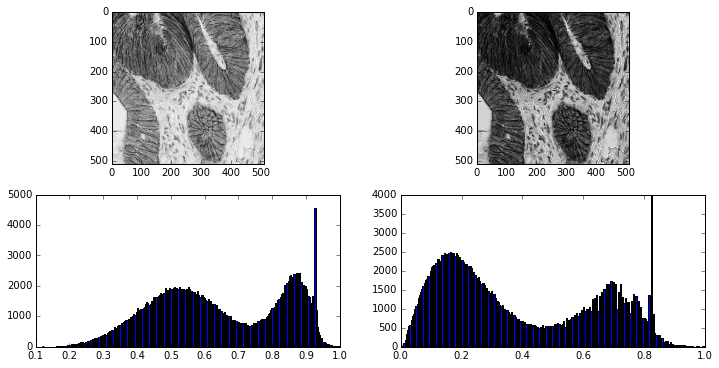

In [24]:
display(image, correction, 256)

> *Immunohistochemical staining with hematoxylin counterstaining*.  This image was acquired at the Center for Microscopy And Molecular Imaging
(CMMI).  It has no known copyright restrictions.

To perform sigmoid correction with given `gain` and `cutoff` coefficients, according to the formula `output = 1/(1 + exp*(gain*(cutoff - input)))`, we employ the function `adjust_sigmoid` in `skimage.exposure`.  For example, with `gain=10.` and `cutoff=0.5` (the default values), we obtain the following enhancement.


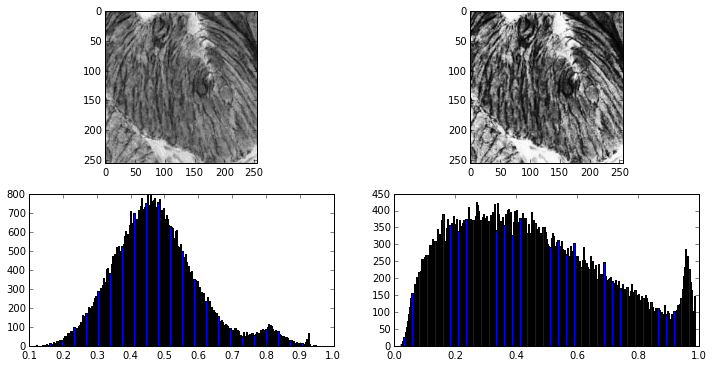

In [26]:
from skimage.exposure import adjust_sigmoid

display(image[:256, :256], adjust_sigmoid, 256)

Note the improvement in the definition of the walls of cells in the enhanced image.

We have already explored *Logarithmic correction* in the previous section, when enhancing the visualization of the frequency of an image.  This is equivalent to applying a vectorized version of `np.log1p` to the intensities.  The corresponding function in the `scikit-image` toolkit is `adjust_log` in the module `exposure`.

### Image Restoration

In this category of image editing, the purpose is to repair the damage produced by post or pre-processing of the image, or even the removal of distortion produced by the acquisition device.  We explore two classic situations:

* Noise reduction
* Sharpening and blurring

#### Noise reduction

In mathematical imaging, *noise* is by definition a random variation of the intensity (or the color) produced by the acquisition device.  Among all the possible types of noise, we acknowledge four key cases:

* *Gaussian noise*.  We add to each pixel a value obtained from a random variable with normal distribution with fixed mean.  We usually allow the same variance on each pixel of the image, but it is feasible to change the variance depending on location.
* *Poisson noise*.  We add to each pixel a value obtained from a random variable with Poisson distribution.
* *Salt and pepper*.  This is a replacement noise, where some pixels are substituted by zeros (black, or pepper), and some pixels are substituted by ones (white, or salt).
* *Speckle*.  This is a multiplicative kind of noise, where each pixel gets modified by the formula `output = input + n * input`.  The value of the modifier `n` is a value obtained from a random variable with uniform distribution of fixed mean and variance.

To emulate all these kinds of noise, we employ the utility `random_noise` from the module `skimage.util`.  Let us illustrate the possibilities over a common image.

In [28]:
from skimage.data import camera
from skimage.util import random_noise

gaussian_noise = random_noise(camera(), 'gaussian', var=0.025)
poisson_noise = random_noise(camera(), 'poisson')
saltpepper_noise = random_noise(camera(), 's&p', salt_vs_pepper=0.45)
speckle_noise = random_noise(camera(), 'speckle', var=0.02)

variance_generator = lambda i,j: 0.25*(i+j)/1022. + 0.001
variances = np.fromfunction(variance_generator, (512, 512))
lclvr_noise = random_noise(camera(), 'localvar', local_vars=variances)


In the last example, we have created a function that assigns a variance between `0.001` and `0.026` depending on the distance to the upper corner of an image.  When we visualize the corresponding noisy version of `skimage.data.camera()`, we see that the level of degradation gets stronger as we get closer to the lower right corner of the picture.

The following is an example of visualization of the corresponding noisy images.


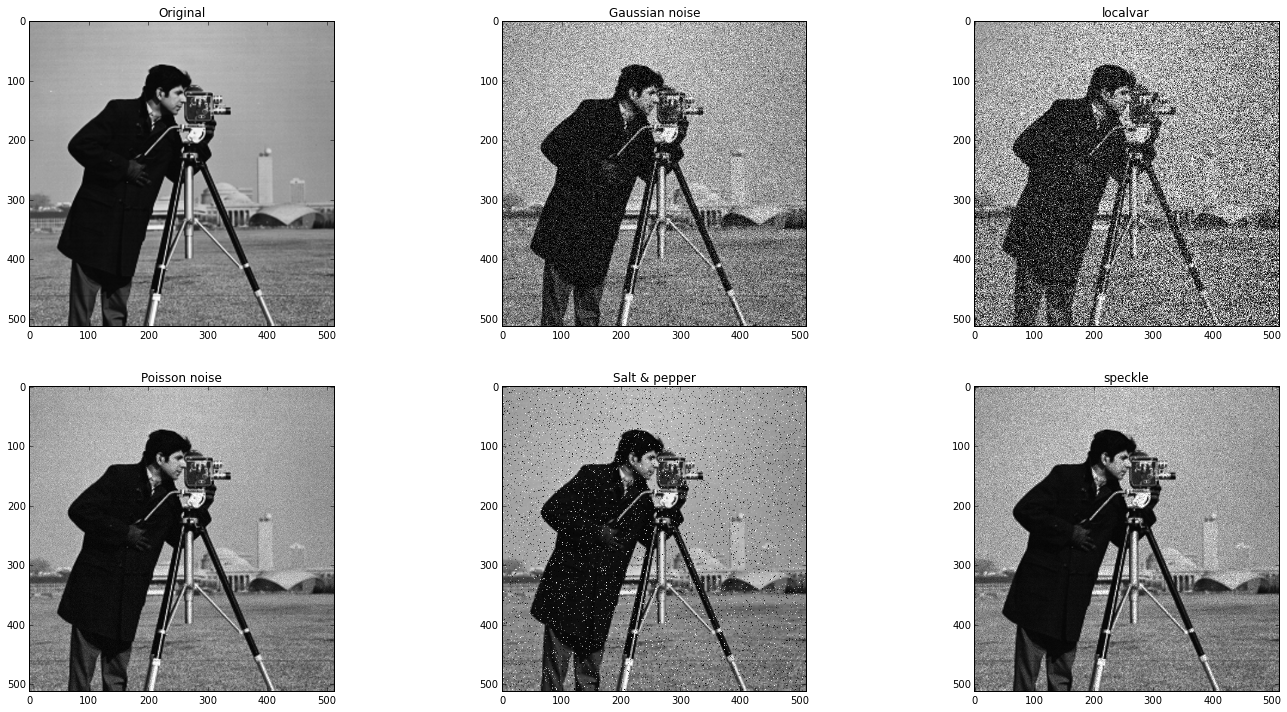

In [30]:
names = ['Original', 'Gaussian noise', 'localvar', 'Poisson noise', 'Salt & pepper', 'speckle']
images = [camera(), gaussian_noise, lclvr_noise, poisson_noise, saltpepper_noise, speckle_noise]

plt.figure(figsize=(24,12))

for k in range(6):
    plt.subplot(2,3,k+1)
    plt.imshow(images[k])
    plt.title(names[k])
    
plt.show()

The purpose of noise reduction is to remove as much of this unwanted signal, so we obtain an image as close to the original as possible.  The trick, of course, is to do so without any previous knowledge of the properties of the noise.

The most basic methods of denoising are the application of either a Gaussian or a median filter.  We explored them both in the previous section.  The former was presented as a smoothing filter (`gaussian_filter`), and the latter was discussed when we explored statistical filters (`median_filter`).  They both offer decent noise removal, but they introduce unwanted artifacts as well.  For example, the Gaussian filter does not preserve edges in images.  The application of any of these methods is also not recommended if preserving texture information is needed.

We have a few more advanced methods in the module `skimage.restoration`, able to tailor denoising to images with specific properties:

* `denoise_bilateral`: The *bilateral filter*.  Useful when preserving edges is important.
* `denoise_tv_bregman`, `denoise_tv_chambolle`: If we require a denoised image with small total variation.
* `nl_means_denoising`: The so-called *Non-local means denoising*.  This method ensures the best results to denoise areas of the image presenting texture.
* `wiener`, `unsupervised_wiener`: The *Wiener-Hunt* deconvolution.  Useful when we have knowledge of the point-spread function at acquisition time.

Let us show by example the performance of one of these methods on some of the noisy images we computed before:


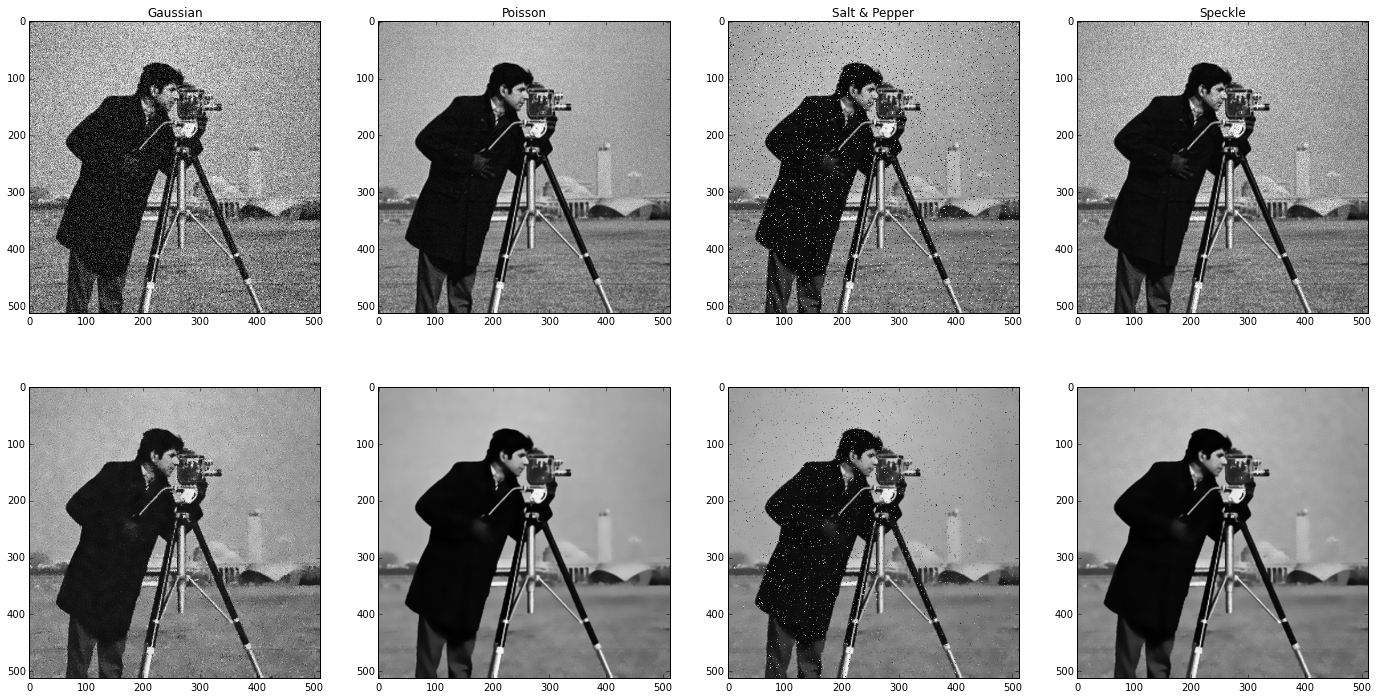

In [32]:
from skimage.restoration import nl_means_denoising as denoise

images = [gaussian_noise, poisson_noise, saltpepper_noise, speckle_noise]
names  = ['Gaussian', 'Poisson', 'Salt & Pepper', 'Speckle']

plt.figure(figsize=(24,12))

for index, image in enumerate(images):
    output = denoise(image, patch_size=5, patch_distance=7)
    plt.subplot(2, 4, index+1)
    plt.imshow(image)
    plt.gray()
    plt.title(names[index])
    plt.subplot(2, 4, index+5)
    plt.imshow(output)

plt.show()

Under each noisy image, we have presented the corresponding result after employing non-local means denoising. 

It is also possible to perform denoising by _thresholding coefficients_, provided we represent images with a transform.  For example, to do a soft thresholding employing Biorthonormal 2.8 wavelets, we would use the package `PyWavelets`:

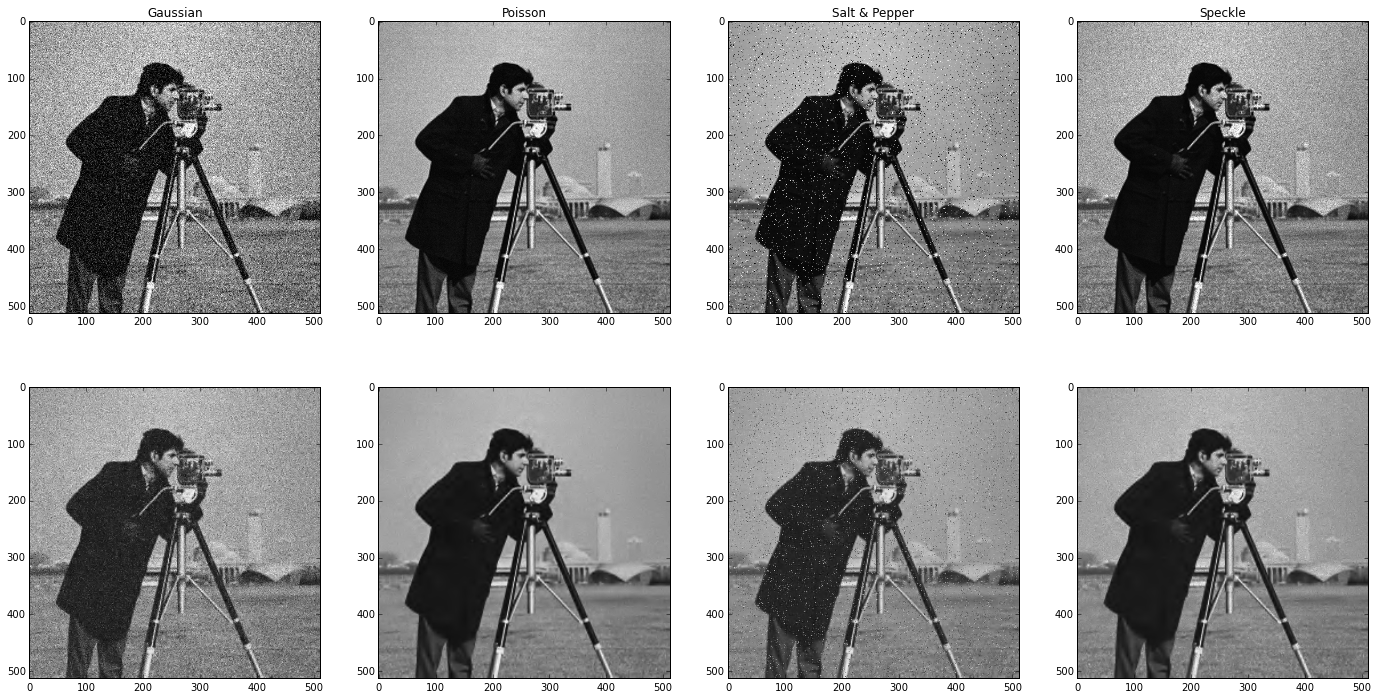

In [34]:
import pywt

def denoise(image, wavelet, noise_var):
    levels = int(np.floor(np.log2(image.shape[0])))
    coeffs = pywt.wavedec2(image, wavelet, level=levels)
    value = noise_var * np.sqrt(2 * np.log2(image.size))
    threshold = lambda x: pywt.thresholding.soft(x, value)
    coeffs = map(threshold, coeffs)
    return pywt.waverec2(coeffs, wavelet)

plt.figure(figsize=(24,12))

for index, image in enumerate(images):
    output = denoise(image, pywt.Wavelet('bior2.8'), noise_var=0.02)
    plt.subplot(2, 4, index+1)
    plt.imshow(image)
    plt.gray()
    plt.title(names[index])
    plt.subplot(2, 4, index+5)
    plt.imshow(output)

plt.show()

Note the results are of comparable quality with those obtained with the previous method.

#### Sharpening and blurring

There are many situations that produce blurred images:

* Incorrect focus at acquisition.
* Movement of the imaging system.
* The point-spread function of the imaging device (like in electron microscopy).
* Graphic-art effects.

For blurring images, we may replicate the effect of a point-spread function by performing convolution of the image with the corresponding kernel.  The Gaussian filter that we used for denoising performs blurring in this fashion.  In the general case, convolution with a given kernel may be done with the routine `convolve` from the module `scipy.ndimage`.  For instance, for a constant kernel supported on a 10-by-10 square, we could do as follows:

In [35]:
from scipy.ndimage import convolve
from skimage.data import page

kernel = np.ones((10, 10))/100.
blurred = convolve(page(), kernel)

To emulate the blurring produced by movement too, we could convolve with a kernel as created below:

In [36]:
from skimage.draw import polygon

x_coords = np.array([14, 14, 24, 26, 24, 18, 18])
y_coords = np.array([ 2, 18, 26, 24, 22, 18,  2])
kernel_2 = np.zeros((32, 32))
kernel_2[polygon(x_coords, y_coords)]= 1.
kernel_2 /= kernel_2.sum()

blurred_motion = convolve(page(), kernel_2)

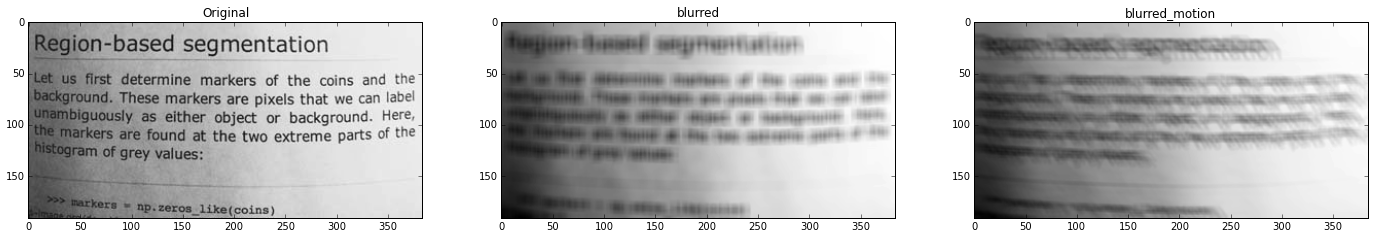

In [38]:
plt.figure(figsize=(24,12))
plt.subplot(131)
plt.imshow(page())
plt.title('Original')
plt.subplot(132)
plt.imshow(blurred)
plt.title('blurred')
plt.subplot(133)
plt.imshow(blurred_motion)
plt.title('blurred_motion')
plt.show()

In order to reverse the effects of convolution when we have knowledge of the degradation process, we perform *deconvolution*.  For example, if we have knowledge of the point-spread function, in the module `skimage.restoration` we have implementations of *Wiener filter* (`wiener`), *unsupervised Wiener filter* (`unsupervised_wiener`), and *Lucy-Richardson deconvolution* (`richardson_lucy`).

We perform deconvolution on `blurred` by applying a Wiener filter.  Note the huge improvement in readability of the text.


In [39]:
from skimage.restoration import wiener

deconv = wiener(blurred, kernel, balance=0.025, clip=False)

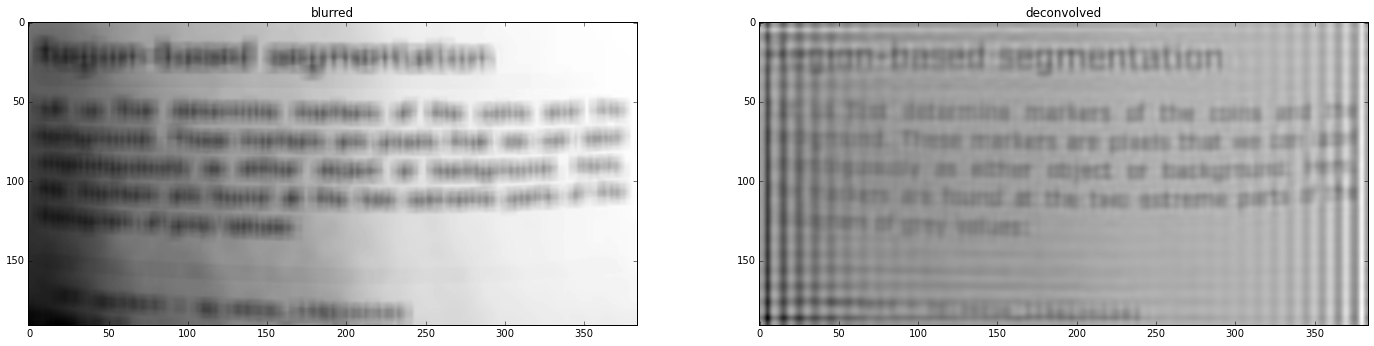

In [40]:
plt.figure(figsize=(24,12))
plt.subplot(121)
plt.imshow(blurred)
plt.title('blurred')
plt.subplot(122)
plt.imshow(deconv)
plt.title('deconvolved')
plt.show()

### Inpainting 

We define _inpainting_ as the replacement of lost or corrupted parts of the image data (mainly small regions or to remove small defects).  

There are ongoing efforts to include an implementation of *Crimini's algorithm* for inpainting in `skimage`.  Until that day comes, there are two other options outside of the `scipy` stack: an implementation of Alexandru Telea's *Fast Marching method*, and an implementation based on fluid dynamics (in particular, the Navier-Stokes equation).  These two implementations can be called from the routine `inpaint` in the `improc` module of `openCV`.  We use Telea's algorithm to illustrate the power of this technique: consider as test image the checkerboard `skimage.data.checkerboard` to which we have removed a region.

In [41]:
from skimage.data import checkerboard

image = checkerboard()
image[25:100, 25:75] = 0.

mask = np.zeros_like(image)
mask[25:100, 25:75] = 1.

from cv2 import inpaint, INPAINT_TELEA, INPAINT_NS

inpainted = inpaint(image, mask, 1, INPAINT_TELEA)

ImportError: No module named cv2

The result illustrates how inpainting works: the intensity of the pixels is obtained from nearby known values.  It is thus no surprise that the inpainted region, yet preserving the geometry of the image, does not compute the correct set of intensities, but the most logical instead.

> For more information on the image processing module `improc` of `OpenCV-python`, follow the API reference at http://docs.opencv.org/modules/imgproc/doc/imgproc.html

Inpainting is very useful to remove unwanted objects from pictures.  Note for example in the page image `skimage.data.page`, the effect of removing large areas contaning linebreaks, and inpainting them with the Navier-Stokes algorithm:


In [42]:
image = page()
image[36:46, :] = image[140:, :] = 0

mask = np.zeros_like(image)
mask[36:46, :] = mask[140:, :] = 1

inpainted = inpaint(image, mask, 5, INPAINT_NS)

NameError: name 'inpaint' is not defined